# 1D Convolutional Neural Network for Regression

In [29]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling

## Import Data

Use the energy efficiency dataset from UCI.

In [30]:
dataset_path = keras.utils.get_file("ENB2012_data.xlsx", "http://archive.ics.uci.edu/ml/machine-learning-databases/00242/ENB2012_data.xlsx")

In [31]:
import pandas as pd

column_names = ['Relative Compactness', 'Surface Area', 'Wall Area', 
                'Roof Area', 'Overall Height', 'Orientation', 
                'Glazing Area', 'Glazing Area Distribution', 
                'Heating Load', 'Cooling Load']
raw_dataset = pd.read_excel(dataset_path, names = column_names, 
                          na_values = '?', comment = '\t', 
                          sep = ' ', skipinitialspace = True)
dataset = raw_dataset.copy()

In [32]:
dataset.head()

,Relative Compactness,Surface Area,Wall Area,Roof Area,Overall Height,Orientation,Glazing Area,Glazing Area Distribution,Heating Load,Cooling Load
0,0.98,514.5,294.0,110.25,7.0,2,0.0,0,15.55,21.33
1,0.98,514.5,294.0,110.25,7.0,3,0.0,0,15.55,21.33
2,0.98,514.5,294.0,110.25,7.0,4,0.0,0,15.55,21.33
3,0.98,514.5,294.0,110.25,7.0,5,0.0,0,15.55,21.33
4,0.90,563.5,318.5,122.50,7.0,2,0.0,0,20.84,28.28


In [33]:
dataset.describe()

,Relative Compactness,Surface Area,Wall Area,Roof Area,Overall Height,Orientation,Glazing Area,Glazing Area Distribution,Heating Load,Cooling Load
count,768.000000,768.000000,768.000000,768.000000,768.00000,768.000000,768.000000,768.00000,768.000000,768.000000
mean,0.764167,671.708333,318.500000,176.604167,5.25000,3.500000,0.234375,2.81250,22.307195,24.587760
std,0.105777,88.086116,43.626481,45.165950,1.75114,1.118763,0.133221,1.55096,10.090204,9.513306
min,0.620000,514.500000,245.000000,110.250000,3.50000,2.000000,0.000000,0.00000,6.010000,10.900000
25%,0.682500,606.375000,294.000000,140.875000,3.50000,2.750000,0.100000,1.75000,12.992500,15.620000
50%,0.750000,673.750000,318.500000,183.750000,5.25000,3.500000,0.250000,3.00000,18.950000,22.080000
75%,0.830000,741.125000,343.000000,220.500000,7.00000,4.250000,0.400000,4.00000,31.667500,33.132500
max,0.980000,808.500000,416.500000,220.500000,7.00000,5.000000,0.400000,5.00000,43.100000,48.030000


## Preprocess data

In [34]:
dataset.isna().sum()
# No NA's

Relative Compactness         0
Surface Area                 0
Wall Area                    0
Roof Area                    0
Overall Height               0
Orientation                  0
Glazing Area                 0
Glazing Area Distribution    0
Heating Load                 0
Cooling Load                 0
dtype: int64

In [35]:
# Split train/test data
total_train = dataset.sample(frac = 0.8, random_state = 0)
total_valid = dataset.drop(total_train.index)

# Predict Heating Load
y_train = total_train.pop('Heating Load')
y_valid = total_valid.pop('Heating Load')
X_train = total_train
X_valid = total_valid

In [36]:
# Normalize
X_train = tf.keras.utils.normalize(X_train, axis = -1, order = 2)
X_valid = tf.keras.utils.normalize(X_valid, axis = -1, order = 2)

In [37]:
X_train.head()

,Relative Compactness,Surface Area,Wall Area,Roof Area,Overall Height,Orientation,Glazing Area,Glazing Area Distribution,Cooling Load
661,0.000774,0.890610,0.373482,0.258564,0.004104,0.003518,0.000469,0.003518,0.020673
122,0.000972,0.901183,0.321851,0.289666,0.004598,0.005255,0.000131,0.002627,0.017827
113,0.001069,0.861844,0.464070,0.198887,0.009471,0.004059,0.000135,0.002706,0.046840
14,0.001161,0.867316,0.451004,0.208156,0.009912,0.005664,0.000000,0.000000,0.029963
529,0.001623,0.852222,0.486984,0.182619,0.011595,0.004969,0.000663,0.001656,0.055225


In [38]:
# Reshape
import pandas as pd

X_train = X_train.to_numpy()
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_valid = X_valid.to_numpy()
X_valid = X_valid.reshape(X_valid.shape[0], X_valid.shape[1], 1)

## Build model

In [68]:
def build_model():
    model = keras.Sequential([
        layers.Conv1D(filters = 32, kernel_size = 3, activation = 'relu', 
                      input_shape = (9, 1)),
        layers.Conv1D(filters = 64, kernel_size = 3, activation = 'relu'),
        layers.Dropout(0.5),
        layers.MaxPooling1D(pool_size = 2),
        layers.Flatten(),
        layers.Dense(64, activation = 'relu'),
        layers.Dense(1)
    ])
    
    optimizer = 'adam'#tf.keras.optimizers.RMSprop(0.001)
    
    model.compile(loss = 'mse',
                 optimizer = optimizer,
                 metrics = ['mae', 'mse'])
    
    return model

In [69]:
model = build_model()

In [70]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_12 (Conv1D)           (None, 7, 32)             128       
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 5, 64)             6208      
_________________________________________________________________
dropout_6 (Dropout)          (None, 5, 64)             0         
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 2, 64)             0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 128)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_13 (Dense)             (None, 1)                

## Train the model

In [71]:
EPOCHS = 100

early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 10)

history = model.fit(
    X_train, y_train,
    epochs = EPOCHS,
    verbose = 1,
    validation_data = (X_valid, y_valid),
    #callbacks = [early_stop, tfdocs.modeling.EpochDots()]
)

Epoch 1/100
20/20 [==============================] - 0s 15ms/step - loss: 601.3372 - mae: 22.3670 - mse: 601.3372 - val_loss: 508.3017 - val_mae: 20.1776 - val_mse: 508.3017
Epoch 2/100
20/20 [==============================] - 0s 9ms/step - loss: 505.1253 - mae: 20.1068 - mse: 505.1253 - val_loss: 372.2412 - val_mae: 16.4771 - val_mse: 372.2412
Epoch 3/100
20/20 [==============================] - 0s 7ms/step - loss: 223.1844 - mae: 11.8632 - mse: 223.1844 - val_loss: 114.7377 - val_mae: 8.3748 - val_mse: 114.7377
Epoch 4/100
20/20 [==============================] - 0s 10ms/step - loss: 110.9757 - mae: 9.3614 - mse: 110.9757 - val_loss: 121.0267 - val_mae: 8.3299 - val_mse: 121.0267
Epoch 5/100
20/20 [==============================] - 0s 10ms/step - loss: 103.5675 - mae: 9.0513 - mse: 103.5675 - val_loss: 117.7750 - val_mae: 8.3194 - val_mse: 117.7750
Epoch 6/100
20/20 [==============================] - 0s 10ms/step - loss: 103.9297 - mae: 9.0657 - mse: 103.9297 - val_loss: 118.6649 - v

20/20 [==============================] - 0s 14ms/step - loss: 35.2746 - mae: 4.4263 - mse: 35.2746 - val_loss: 33.4849 - val_mae: 4.1655 - val_mse: 33.4849
Epoch 50/100
20/20 [==============================] - 0s 15ms/step - loss: 35.1979 - mae: 4.4257 - mse: 35.1979 - val_loss: 38.2297 - val_mae: 4.5863 - val_mse: 38.2297
Epoch 51/100
20/20 [==============================] - 0s 20ms/step - loss: 32.0329 - mae: 4.2044 - mse: 32.0329 - val_loss: 36.9121 - val_mae: 4.5465 - val_mse: 36.9121
Epoch 52/100
20/20 [==============================] - 0s 13ms/step - loss: 31.3246 - mae: 4.2093 - mse: 31.3246 - val_loss: 31.5527 - val_mae: 4.1331 - val_mse: 31.5527
Epoch 53/100
20/20 [==============================] - 0s 19ms/step - loss: 33.3645 - mae: 4.3403 - mse: 33.3645 - val_loss: 31.0705 - val_mae: 4.1059 - val_mse: 31.0705
Epoch 54/100
20/20 [==============================] - 0s 18ms/step - loss: 30.9593 - mae: 4.1394 - mse: 30.9593 - val_loss: 34.0699 - val_mae: 4.3512 - val_mse: 34.0699

20/20 [==============================] - 0s 20ms/step - loss: 28.7977 - mae: 3.9975 - mse: 28.7977 - val_loss: 40.0043 - val_mae: 4.7386 - val_mse: 40.0043
Epoch 98/100
20/20 [==============================] - 0s 19ms/step - loss: 26.8731 - mae: 3.8115 - mse: 26.8731 - val_loss: 40.0751 - val_mae: 4.7403 - val_mse: 40.0751
Epoch 99/100
20/20 [==============================] - 0s 12ms/step - loss: 25.2746 - mae: 3.7148 - mse: 25.2746 - val_loss: 42.6406 - val_mae: 4.9860 - val_mse: 42.6406
Epoch 100/100
20/20 [==============================] - 0s 10ms/step - loss: 27.4902 - mae: 3.8350 - mse: 27.4902 - val_loss: 39.4416 - val_mae: 4.7181 - val_mse: 39.4416


## Evaluate the model

5/5 - 0s - loss: 39.4416 - mae: 4.7181 - mse: 39.4416


[39.44158935546875, 4.7180585861206055, 39.44158935546875]

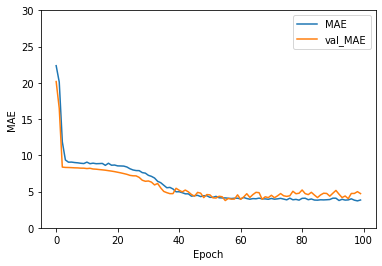

In [72]:
import matplotlib.pyplot as plt

plt.plot(history.history['mae'], label = 'MAE')
plt.plot(history.history['val_mae'], label = 'val_MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.ylim([0, 30])
plt.legend(loc = 'upper right')

model.evaluate(X_valid, y_valid, verbose = 2)

5/5 - 0s - loss: 39.4416 - mae: 4.7181 - mse: 39.4416


[39.44158935546875, 4.7180585861206055, 39.44158935546875]

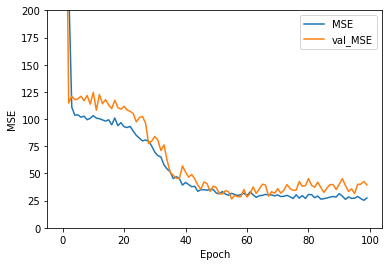

In [73]:
plt.plot(history.history['mse'], label = 'MSE')
plt.plot(history.history['val_mse'], label = 'val_MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.ylim([0, 200])
plt.legend(loc = 'upper right')

model.evaluate(X_valid, y_valid, verbose = 2)

## Make predictions

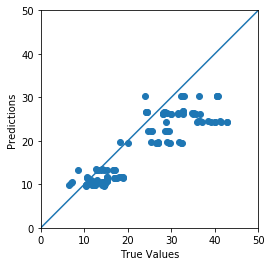

In [74]:
preds = model.predict(X_valid).flatten()

a = plt.axes(aspect = 'equal')
plt.scatter(y_valid, preds)
plt.xlabel('True Values')
plt.ylabel('Predictions')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

View error distribution.

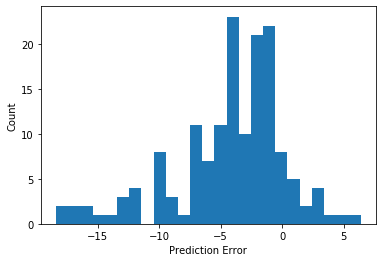

In [75]:
error = preds - y_valid
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error")
_ = plt.ylabel("Count")